In [ ]:
!pip3 install geopandas
!pip3 install Shapely

import os
import math
import zipfile
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import geopandas as gpd
from shapely.geometry import Point
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
# from minisom import MiniSom
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from zipfile import ZipFile
# Mount to nipchan@uscs.edu drive
# print(os.listdir())
from google.colab import drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#for Nick
# Select wkdir
if "drive" in os.listdir():
    path = "drive/My Drive/MSMC-Curve-Analysis/MSMC-Exploratory-Analysis/bird-analysis"
    os.chdir(path) # Made a directory in home Drive called "data"
np.seterr(divide = "ignore")

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
#for erik
drive.mount('/content/drive')
if "drive" in os.listdir():
    path = "drive/My Drive/MSMC-Exploratory-Analysis/bird-analysis"
    os.chdir(path) # Made a directory in home Drive called "data"
np.seterr(divide = "ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
Goals: 

- anova and glm are great
    - Run anova on my favorite trait (HWI or mass)
        - ANOVA will tell me if there is something going on within the trait grouping, but not what specifically (nothing like between group diffs)
    - For traits that return a nice ANOVA result, see if their within cluster groupings are sig (T-test on the means of each box -> find p-value for diff)
    - Rerun normalization with something like the median instead of the max
    - Repeat ANOVA to see if anything improved
    - Find a value like inertia or some sort of time series variance 

    - Labels: Curve Cluster Assignments
    - Features: ANOVA Traits (Continuous values)

- draft up small report on findings

- Generate boxplots of bird wing size (of birds within sample) over cluster labels
    - Identify the trait with the most inter-cluster variation
- Generate some hists of categorical data for each cluster label

- Get out some trait data like size and see if delta stat and rtrees yield anything intersting
    - Test pagel's lambda on bird sizes
    - Traits of interest in data:
        - Categorical:
            - Trophic.Niche
            - Primary.Lifestyle
            - Habitat
            - Species.Status
        - Continuous: 
            - Geography
            - Body features

- Determine if delta statistic is suitable for determining phylogenetic signal for traits of categorical data


'''


os.listdir()

['bird-trait-stuff.ipynb',
 'Supplementary dataset 2.xlsx',
 'AVONET Supplementary dataset 1.xlsx',
 'clusters_metadata.csv']

In [ ]:
# Load datasets
df_dict = pd.read_excel("./AVONET Supplementary dataset 1.xlsx", sheet_name=list(range(11))) # Main meta-data
df_clusterLabels = pd.read_csv("../results/lists/curve-cluster-table.tsv", sep="\t") # Cluster label data
df_unnormalized_clusterLabels = pd.read_csv("../results/lists/curve-cluster-unnormalized-table.tsv", sep="\t")
# Choose AVONET3_BirdTree df (index=3) since it is the most comprehensive so far
df_avonet3 = df_dict[3]
traits_of_interest = df_avonet3.select_dtypes(include=[int, float]) # Numerical traits
# Grab list of species names from df_clusterLabels and index the into df_avonet3 
# to retrieve proper data entries

df_clusterLabels_tmp = df_clusterLabels.set_index("Latin name")

# Set latin names as index for df_avonet3
avonet3_indices_raw = df_avonet3["Species3"].tolist()
avonet3_indices_raw = [i.replace(" ", "_") for i in avonet3_indices_raw]
df_avonet3["Latin name"] = avonet3_indices_raw
df_avonet3 = df_avonet3.set_index("Latin name") # Convert AVONET metadata Latin names into indices, accessible by current label df
# Next task is to correct latin names with taxanomical synonyms, then insert boost after u inshirt

In [ ]:
# '''
# Choose AVONET3_BirdTree df (index=3) since it is the most comprehensive so far
# Traits of interest: I - S, Y - AJ -> 

# ['Beak.Length_Culmen',
#  'Beak.Length_Nares',
#  'Beak.Width',
#  'Beak.Depth',
#  'Tarsus.Length',
#  'Wing.Length',
#  'Kipps.Distance',
#  'Secondary1',
#  'Hand-Wing.Index',
#  'Tail.Length',
#  'Mass',
#  'Habitat',
#  'Habitat.Density',
#  'Migration',
#  'Trophic.Level',
#  'Trophic.Niche',
#  'Primary.Lifestyle',
#  'Min.Latitude',
#  'Max.Latitude',
#  'Centroid.Latitude',
#  'Centroid.Longitude',
#  'Range.Size',
#  'Species.Status']
# '''

# df_avonet3 = df_dict[3]
# # traits_of_interest = list(df_avonet3.columns[8:19]) + list(df_avonet3.columns[24:])
# traits_of_interest = df_avonet3.select_dtypes(include=[int, float]) # Numerical traits
# # Grab list of species names from df_clusterLabels and index the into df_avonet3 
# # to retrieve proper data entries



In [ ]:
# # Set latin names as index for df_avonet3
# avonet3_indices_raw = df_avonet3["Species3"].tolist()
# avonet3_indices_raw = [i.replace(" ", "_") for i in avonet3_indices_raw]
# df_avonet3["Latin name"] = avonet3_indices_raw
# df_avonet3 = df_avonet3.set_index("Latin name") # Convert AVONET metadata Latin names into indices, accessible by current label df
# # Next task is to correct latin names with taxanomical synonyms, then insert boost after u inshirt

In [ ]:
# These names are found in the cluster labels df but not avonet3
# Potential cause is that the cluster labels names aren't actually the
# most widely recognized scientific names of the birds
# SOLUTION: Manually check these bogus bird names, AVONET usable scientific names are typically taxonomical synonyms or old names of these clusterLabel names

# e.g. Edolisoma coerulescens is AKA Coracina coerulescens on Google n stuff
scinames = ["Gallicolumba beccarii", "Pycnonotus atriceps", "Callaeas cinereus", "Larus maculipennis",
        "Platysteira castanea", "Coracina coerulescens", "Cettia vulcania", "Oceanodroma tethys",
        "Larus argentatus", "Nectarinia aspasia", "Eupodotis_ruficrista", "Rostratula semicollaris", 
        "Parus atricapillus", "Megalaima haemacephala", "Phylloscopus sibilatrix", "Dendroica kirtlandii",
        "Paradoxornis webbianus", "Stachyris dennistouni", "Porzana atra"] # Hand picked/found scientific names (found in alphabetical order of OG names)
ogNames = sorted([i for i in df_clusterLabels_tmp.index if i not in df_avonet3.index]) # Dict with "coloquial" names as keys and scientific names as vals
dict_og2sci = {key : scinames[idx].replace(" ", "_") for idx, key in enumerate(ogNames)}

    
for idx, name in enumerate(ogNames):
    name_to_add = scinames[idx].replace(" ", "_")
    print(idx, ":", name, "->", scinames[idx])
    

df_clusterLabels["Latin name"] = [i if i not in dict_og2sci else dict_og2sci[i] for i in df_clusterLabels["Latin name"]] # Makes changes to df_clusterLabels
df_unnormalized_clusterLabels["Latin name"] = [i if i not in dict_og2sci else dict_og2sci[i] for i in df_unnormalized_clusterLabels["Latin name"]] # Makes changes to df_clusterLabels

df_clusterLabels = df_clusterLabels.set_index("Latin name")
df_unnormalized_clusterLabels = df_unnormalized_clusterLabels.set_index("Latin name")

0 : Alopecoenas_beccarii -> Gallicolumba beccarii
1 : Brachypodius_atriceps -> Pycnonotus atriceps
2 : Callaeas_wilsoni -> Callaeas cinereus
3 : Chroicocephalus_maculipennis -> Larus maculipennis
4 : Dyaphorophyia_castanea -> Platysteira castanea
5 : Edolisoma_coerulescens -> Coracina coerulescens
6 : Horornis_vulcanius -> Cettia vulcania
7 : Hydrobates_tethys -> Oceanodroma tethys
8 : Larus_smithsonianus -> Larus argentatus
9 : Leptocoma_aspasia -> Nectarinia aspasia
10 : Lophotis_ruficrista -> Eupodotis_ruficrista
11 : Nycticryphes_semicollaris -> Rostratula semicollaris
12 : Poecile_atricapillus -> Parus atricapillus
13 : Psilopogon_haemacephalus -> Megalaima haemacephala
14 : Rhadina_sibilatrix -> Phylloscopus sibilatrix
15 : Setophaga_kirtlandii -> Dendroica kirtlandii
16 : Sinosuthora_webbiana -> Paradoxornis webbianus
17 : Sterrhoptilus_dennistouni -> Stachyris dennistouni
18 : Zapornia_atra -> Porzana atra


In [ ]:
pd.set_option("display.max_columns", None)
df_avonet3.loc[df_clusterLabels.index]

,Species3,Family3,Order3,Total.individuals,Female,Male,Unknown,Complete.measures,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-Wing.Index,Tail.Length,Mass,Mass.Source,Mass.Refs.Other,Inference,Traits.inferred,Reference.species,Habitat,Habitat.Density,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size,Species.Status
Latin name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aegithalos_caudatus,Aegithalos caudatus,Aegithalidae,Passeriformes,21,10,11,0,8,7.6,4.5,2.6,3.3,15.8,61.4,13.3,48.2,21.6,79.8,8.60,Dunning,NaN,NO,NaN,NaN,Forest,2.0,1.0,Carnivore,Invertivore,Insessorial,23.12,68.30,51.23,74.925982,20041677.81,Extant
Aegotheles_bennettii,Aegotheles bennettii,Aegothelidae,Apodiformes,7,4,3,0,7,16.5,5.9,4.8,4.0,19.8,127.5,39.6,87.8,31.1,114.9,60.00,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Carnivore,Invertivore,Insessorial,-10.73,-0.79,-5.63,143.975296,199259.89,Extant
Alca_torda,Alca torda,Alcidae,Charadriiformes,6,2,2,2,4,42.8,21.1,9.2,23.1,32.4,209.3,116.5,88.5,56.8,94.7,725.99,Dunning,NaN,NO,NaN,NaN,Marine,3.0,3.0,Carnivore,Aquatic predator,Aquatic,43.10,76.41,61.38,-19.929891,1228730.51,Extant
Aleadryas_rufinucha,Aleadryas rufinucha,Pachycephalidae,Passeriformes,5,2,3,0,4,20.3,11.2,4.9,7.3,30.2,84.8,12.2,70.8,14.7,70.2,40.50,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Carnivore,Invertivore,Insessorial,-10.11,-0.49,-5.12,141.605312,150684.68,Extant
Gallicolumba_beccarii,Gallicolumba beccarii,Columbidae,Columbiformes,8,4,4,0,8,16.4,8.7,2.4,3.2,26.8,104.2,30.5,73.7,29.3,56.0,78.73,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Herbivore,Omnivore,Terrestrial,-11.85,-0.49,-5.52,144.981323,239191.41,Extant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Parus_atricapillus,Parus atricapillus,Paridae,Passeriformes,13,5,7,1,7,10.3,7.2,3.7,4.0,16.8,64.4,12.0,52.5,18.6,61.7,10.80,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Omnivore,Invertivore,Insessorial,34.20,65.98,50.08,-104.989110,9078514.18,Extant
Pomatostomus_ruficeps,Pomatostomus ruficeps,Pomatostomidae,Passeriformes,9,5,3,1,4,27.7,17.9,4.1,6.6,28.2,85.9,10.1,75.4,11.7,89.2,57.80,Dunning,NaN,NO,NaN,NaN,Shrubland,2.0,2.0,Carnivore,Invertivore,Generalist,-37.09,-24.69,-30.72,142.889630,1074854.31,Extant
Pteruthius_melanotis,Pteruthius melanotis,Timaliidae,Passeriformes,10,2,8,0,4,11.8,5.4,4.0,3.9,19.9,59.3,10.2,49.2,17.2,41.4,13.30,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Carnivore,Invertivore,Insessorial,3.39,30.31,23.62,97.678479,841041.72,Extant


In [ ]:
df_clusterLabels

,Sample,Labels
Latin name,,
Aegithalos_caudatus,Aegithalos_caudatus_GCA_013389925.1_msmc2.final,13
Aegotheles_bennettii,Aegotheles_bennettii_GCA_013398125.1_msmc2.final,1
Alca_torda,Alca_torda_GCA_013398245.1_msmc2.final,9
Aleadryas_rufinucha,Aleadryas_rufinucha_GCA_013397815.1_msmc2.final,10
Gallicolumba_beccarii,Alopecoenas_beccarii_GCA_013399365.1_msmc2.final,10
...,...,...
Parus_atricapillus,Poecile_atricapillus_GCA_013398625.1_msmc2.final,6
Pomatostomus_ruficeps,Pomatostomus_ruficeps_GCA_013400735.1_msmc2.final,7
Pteruthius_melanotis,Pteruthius_melanotis_GCA_013401235.1_msmc2.final,12


In [ ]:
df_clusterLabels.join(df_unnormalized_clusterLabels, on=df_clusterLabels.index, lsuffix="Sample")

,SampleSample,LabelsSample,Sample,Labels
Latin name,,,,
Aegithalos_caudatus,Aegithalos_caudatus_GCA_013389925.1_msmc2.final,13,Aegithalos_caudatus_GCA_013389925.1_msmc2.final,0
Aegotheles_bennettii,Aegotheles_bennettii_GCA_013398125.1_msmc2.final,1,Aegotheles_bennettii_GCA_013398125.1_msmc2.final,0
Alca_torda,Alca_torda_GCA_013398245.1_msmc2.final,9,Alca_torda_GCA_013398245.1_msmc2.final,0
Aleadryas_rufinucha,Aleadryas_rufinucha_GCA_013397815.1_msmc2.final,10,Aleadryas_rufinucha_GCA_013397815.1_msmc2.final,0
Gallicolumba_beccarii,Alopecoenas_beccarii_GCA_013399365.1_msmc2.final,10,Alopecoenas_beccarii_GCA_013399365.1_msmc2.final,0
...,...,...,...,...
Parus_atricapillus,Poecile_atricapillus_GCA_013398625.1_msmc2.final,6,Poecile_atricapillus_GCA_013398625.1_msmc2.final,0
Pomatostomus_ruficeps,Pomatostomus_ruficeps_GCA_013400735.1_msmc2.final,7,Pomatostomus_ruficeps_GCA_013400735.1_msmc2.final,0
Pteruthius_melanotis,Pteruthius_melanotis_GCA_013401235.1_msmc2.final,12,Pteruthius_melanotis_GCA_013401235.1_msmc2.final,0


In [ ]:
'''
If I need more individual data, see AVONET_Raw_Data sheet from loaded data. It
contains per sample data on birds of all kinds. Will help add to sample size in terms
of same species samples.
'''
df_joined = df_avonet3.join(df_clusterLabels, on=df_avonet3.index).dropna(subset=["Labels"])
df_unnormalized_joined = df_avonet3.join(df_unnormalized_clusterLabels, on=df_avonet3.index).dropna(subset=["Labels"])

# Numerical data with passeriformes
df_avonet3_passeriformes = df_avonet3.loc[df_avonet3["Order3"] == "Passeriformes"]
df_joined_passeriformes = df_avonet3_passeriformes.join(df_clusterLabels, on=df_avonet3_passeriformes.index).dropna(subset=["Labels"])
df_unnormalized_joined_passeriformes = df_avonet3_passeriformes.join(df_unnormalized_clusterLabels, on=df_avonet3_passeriformes.index).dropna(subset=["Labels"])

# Categorical data
df_avonet3_categorical = df_avonet3.select_dtypes(exclude=[int, float])


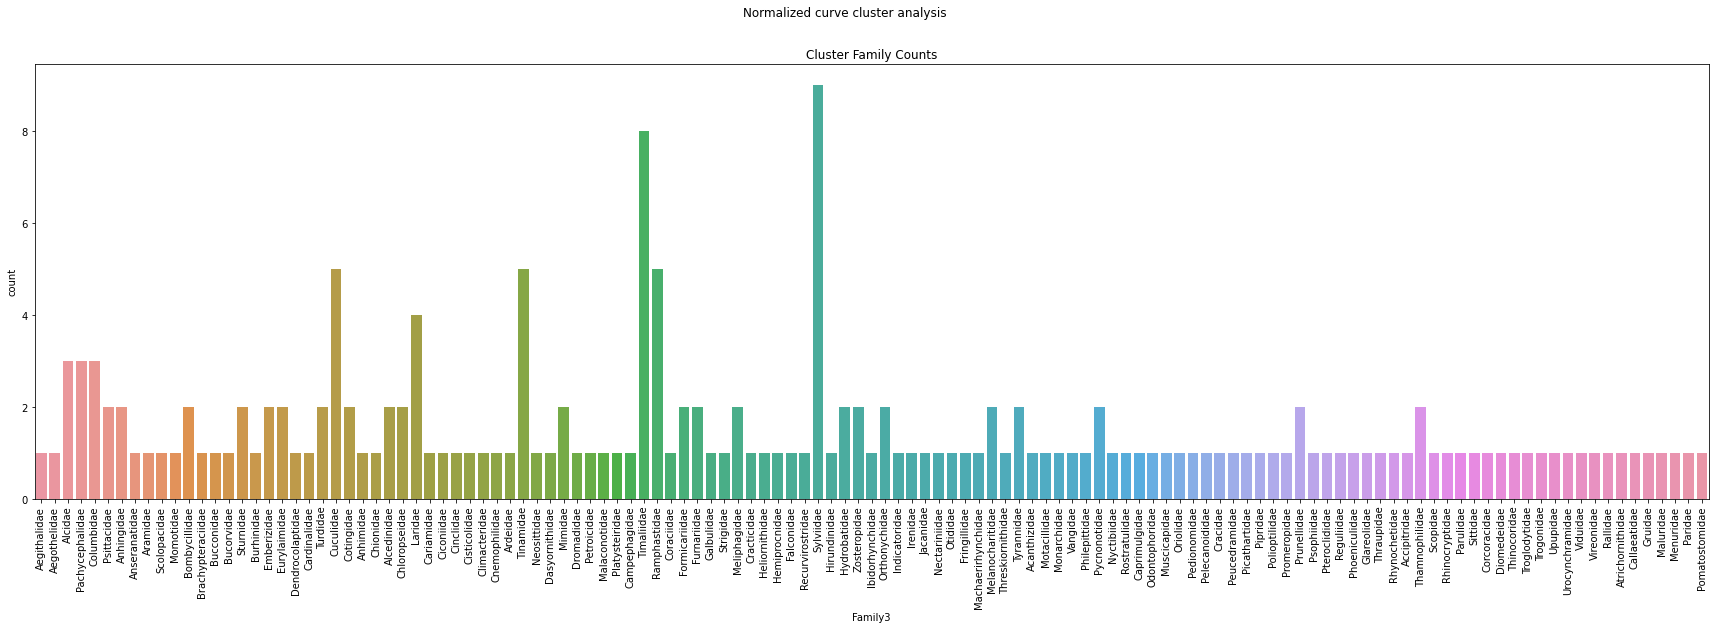

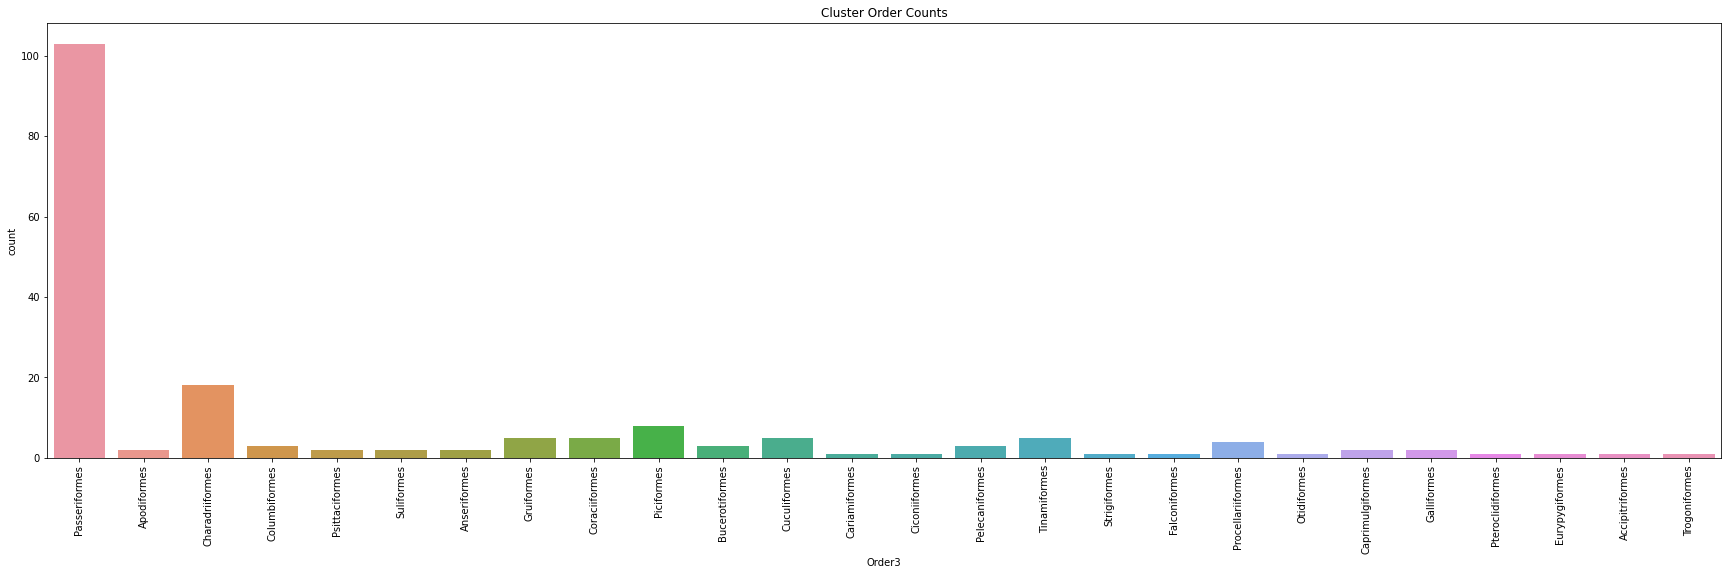

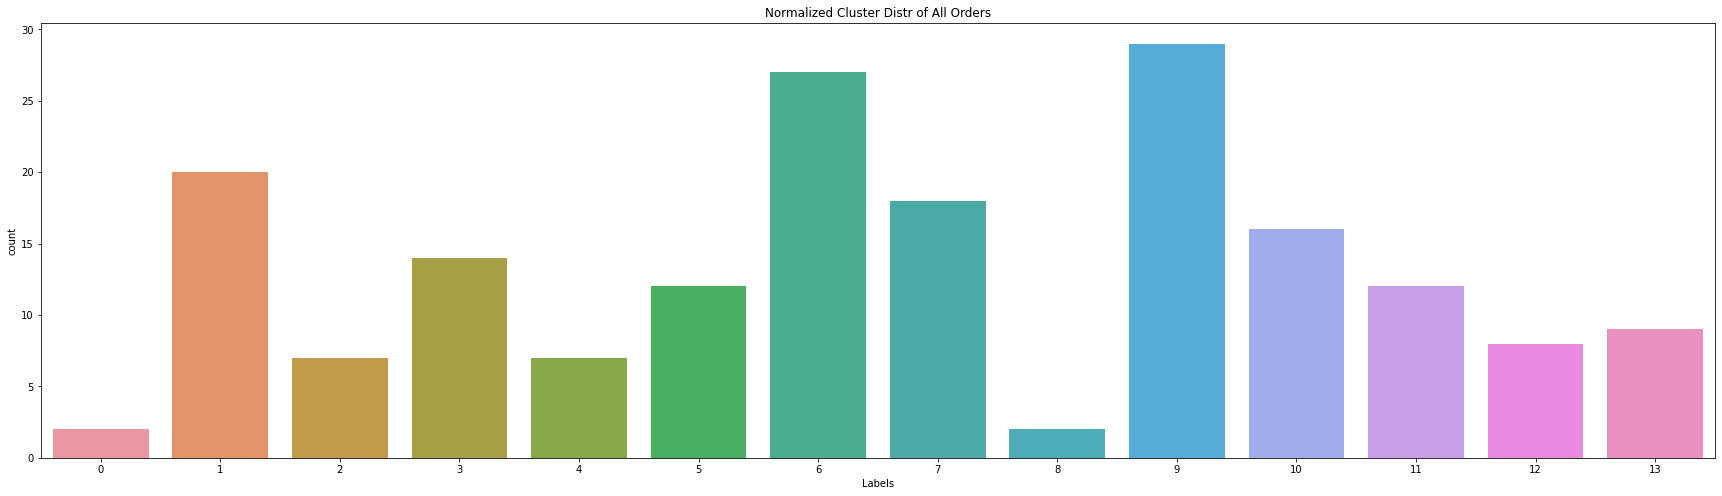

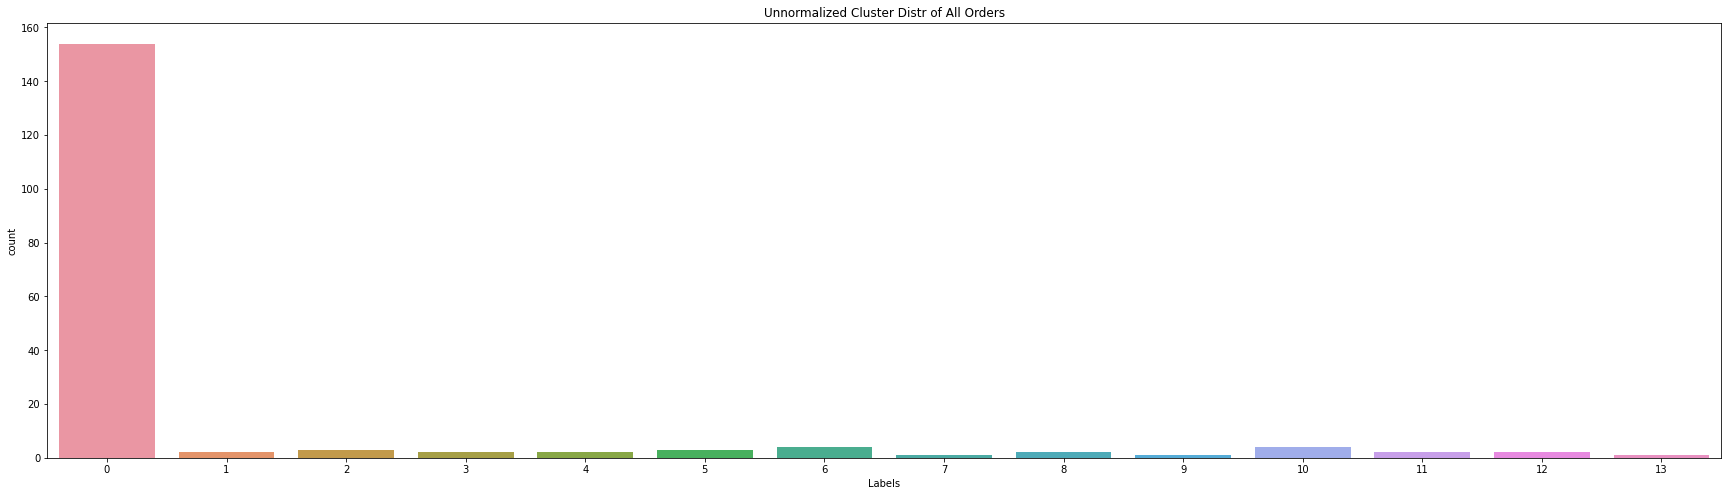

In [ ]:
'''
Curve cluster analysis

Plot:
1.) Family distr
2.) Order distr 
3.) Cluster distr by Order
'''

data = df_avonet3.loc[df_clusterLabels.index]
plt.figure(figsize=(30,8))
plt.xticks(rotation=90)
plt.suptitle("Normalized curve cluster analysis")
ac_countplot = sns.countplot(data = data, x = "Family3", dodge=False)
plt.title("Cluster Family Counts")

plt.figure(figsize=(30,8))
plt.xticks(rotation=90)
ac_countplot = sns.countplot(data = data, x = "Order3", dodge=False)
plt.title("Cluster Order Counts")

plt.figure(figsize=(30,8))
plt.title("Normalized Cluster Distr of All Orders")
ac_countplot = sns.countplot(data = df_clusterLabels.reset_index(), x = "Labels",  hue="Labels", dodge=False)
ac_countplot.legend_.remove()

plt.figure(figsize=(30,8))
plt.title("Unnormalized Cluster Distr of All Orders")
ac_countplot = sns.countplot(data = df_unnormalized_clusterLabels.reset_index(), x = "Labels",  hue="Labels", dodge=False)
ac_countplot.legend_.remove()

In [ ]:
df_avonet3.select_dtypes(include=[int, float])


,Total.individuals,Female,Male,Unknown,Complete.measures,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-Wing.Index,Tail.Length,Mass,Habitat.Density,Migration,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size
Latin name,,,,,,,,,,,,,,,,,,,,,,,
Accipiter_albogularis,5,2,0,3,4,27.7,17.8,10.6,14.7,62.0,235.2,81.8,159.5,33.9,169.0,248.75,1.0,2.0,-11.73,-4.02,-8.15,158.493765,37461.21
Accipiter_badius,10,4,6,0,8,20.6,12.1,8.8,11.6,43.0,186.7,62.5,127.4,32.9,140.6,131.15,2.0,3.0,-29.47,46.39,8.23,44.982464,22374973.00
Accipiter_bicolor,6,2,2,2,4,26.5,14.8,9.2,13.5,57.5,231.8,46.4,189.6,19.8,188.4,287.54,2.0,2.0,NaN,NaN,NaN,NaN,NaN
Accipiter_brachyurus,4,4,0,0,3,22.5,14.0,8.9,11.9,61.2,202.2,64.1,138.1,31.7,140.8,142.00,1.0,2.0,-6.31,-4.08,-5.45,150.681314,35580.71
Accipiter_brevipes,8,4,4,0,4,21.1,12.1,8.7,11.1,46.4,217.6,87.8,129.9,40.2,153.5,186.48,1.0,3.0,31.19,55.86,45.24,45.327340,2936751.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trogon_personatus,23,12,10,1,5,18.9,11.7,8.5,8.9,14.3,125.7,46.9,78.3,37.5,157.8,63.39,1.0,1.0,-20.40,11.16,-2.92,-71.921352,745904.62
Trogon_rufus,22,10,12,0,8,19.9,11.7,8.9,9.8,13.1,113.1,42.8,70.3,37.9,130.9,53.80,1.0,1.0,-29.64,16.03,-5.73,-61.118304,6666233.02
Trogon_surrucura,8,4,4,0,8,19.5,11.8,9.3,9.9,15.3,133.2,51.2,82.0,38.5,132.7,73.29,1.0,1.0,-31.18,-10.87,-22.48,-49.892745,1550766.21


In [ ]:
# sns.heatmap(df_avonet3)

In [ ]:
data

,Species3,Family3,Order3,Total.individuals,Female,Male,Unknown,Complete.measures,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-Wing.Index,Tail.Length,Mass,Mass.Source,Mass.Refs.Other,Inference,Traits.inferred,Reference.species,Habitat,Habitat.Density,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size,Species.Status
Latin name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aegithalos_caudatus,Aegithalos caudatus,Aegithalidae,Passeriformes,21,10,11,0,8,7.6,4.5,2.6,3.3,15.8,61.4,13.3,48.2,21.6,79.8,8.60,Dunning,NaN,NO,NaN,NaN,Forest,2.0,1.0,Carnivore,Invertivore,Insessorial,23.12,68.30,51.23,74.925982,20041677.81,Extant
Aegotheles_bennettii,Aegotheles bennettii,Aegothelidae,Apodiformes,7,4,3,0,7,16.5,5.9,4.8,4.0,19.8,127.5,39.6,87.8,31.1,114.9,60.00,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Carnivore,Invertivore,Insessorial,-10.73,-0.79,-5.63,143.975296,199259.89,Extant
Alca_torda,Alca torda,Alcidae,Charadriiformes,6,2,2,2,4,42.8,21.1,9.2,23.1,32.4,209.3,116.5,88.5,56.8,94.7,725.99,Dunning,NaN,NO,NaN,NaN,Marine,3.0,3.0,Carnivore,Aquatic predator,Aquatic,43.10,76.41,61.38,-19.929891,1228730.51,Extant
Aleadryas_rufinucha,Aleadryas rufinucha,Pachycephalidae,Passeriformes,5,2,3,0,4,20.3,11.2,4.9,7.3,30.2,84.8,12.2,70.8,14.7,70.2,40.50,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Carnivore,Invertivore,Insessorial,-10.11,-0.49,-5.12,141.605312,150684.68,Extant
Gallicolumba_beccarii,Gallicolumba beccarii,Columbidae,Columbiformes,8,4,4,0,8,16.4,8.7,2.4,3.2,26.8,104.2,30.5,73.7,29.3,56.0,78.73,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Herbivore,Omnivore,Terrestrial,-11.85,-0.49,-5.52,144.981323,239191.41,Extant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Parus_atricapillus,Parus atricapillus,Paridae,Passeriformes,13,5,7,1,7,10.3,7.2,3.7,4.0,16.8,64.4,12.0,52.5,18.6,61.7,10.80,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Omnivore,Invertivore,Insessorial,34.20,65.98,50.08,-104.989110,9078514.18,Extant
Pomatostomus_ruficeps,Pomatostomus ruficeps,Pomatostomidae,Passeriformes,9,5,3,1,4,27.7,17.9,4.1,6.6,28.2,85.9,10.1,75.4,11.7,89.2,57.80,Dunning,NaN,NO,NaN,NaN,Shrubland,2.0,2.0,Carnivore,Invertivore,Generalist,-37.09,-24.69,-30.72,142.889630,1074854.31,Extant
Pteruthius_melanotis,Pteruthius melanotis,Timaliidae,Passeriformes,10,2,8,0,4,11.8,5.4,4.0,3.9,19.9,59.3,10.2,49.2,17.2,41.4,13.30,Dunning,NaN,NO,NaN,NaN,Forest,1.0,1.0,Carnivore,Invertivore,Insessorial,3.39,30.31,23.62,97.678479,841041.72,Extant


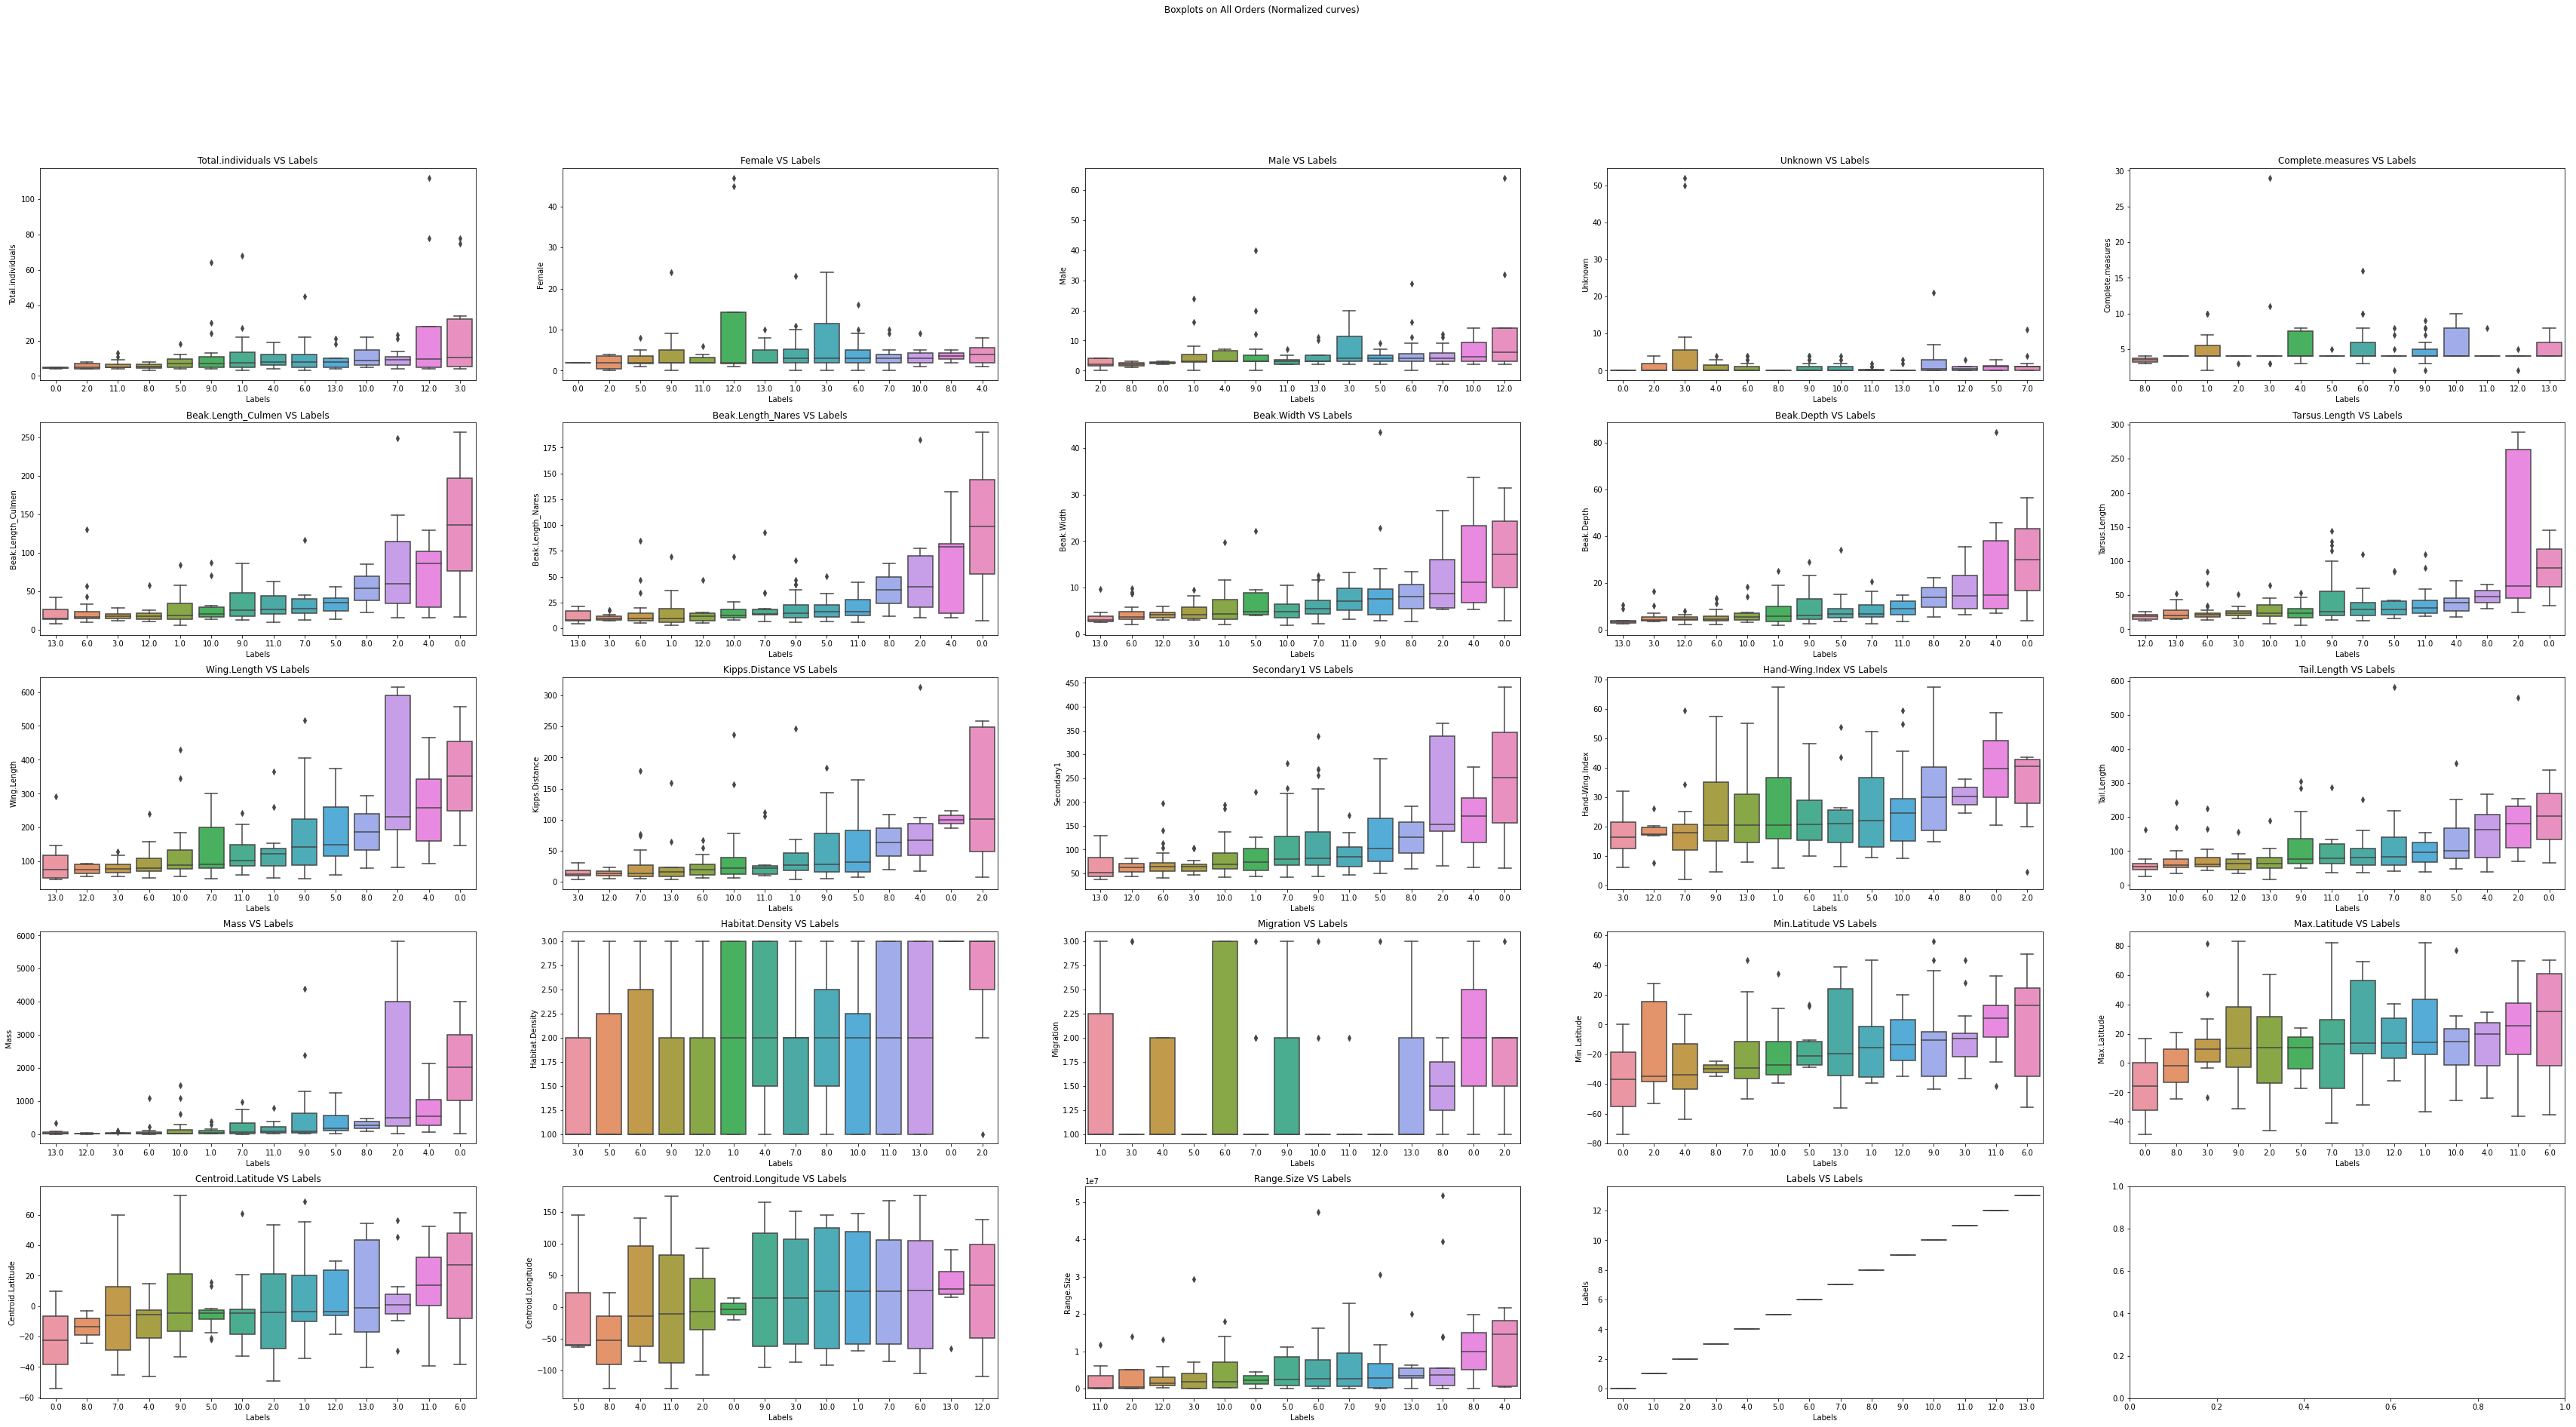

In [ ]:
'''
There seems to be some sort of connection between some size attributes and Cluster 10
however, cluster 10 only has ~5 samples.

When examining clusters with high counts (>20), Labels 1 and 2 display similar 
values with very low variation.

Cluster 8 (around 7 samples) stands out on hand-wind index but is normal on all
other traits.
'''
data = df_joined.loc[df_clusterLabels.index] # Using joined version of df_avonet3 (just has extra column for labels)
data.to_csv("../results/lists/annotated-curve-cluster-table.tsv", sep='\t')

y_s_num = df_joined.select_dtypes(include = [float, int]).columns # 12 things

rows = 5
cols = 5
tot = rows*cols
fig, axs = plt.subplots(rows, cols, figsize=(60, 30))
fig.suptitle("Boxplots on All Orders (Normalized curves)")
for i in range(rows): # 0, 1
    for j in range(cols): # 0, 1, 2
        idx = j + i*(cols)
        if idx < len(y_s_num):
            y = y_s_num[idx]
            my_order = data.groupby(["Labels"])[y].median().sort_values().index # Sort by feature medians in ascending order
            sns.boxplot(data = data, 
                x = data["Labels"], y = data[y],
                ax = axs[i, j],
                order = my_order)
            
            axs[i, j].set_xlabel("Labels")
            axs[i, j].set_ylabel(f"{y}")
            axs[i, j].set_title(f"{y} VS Labels")
        

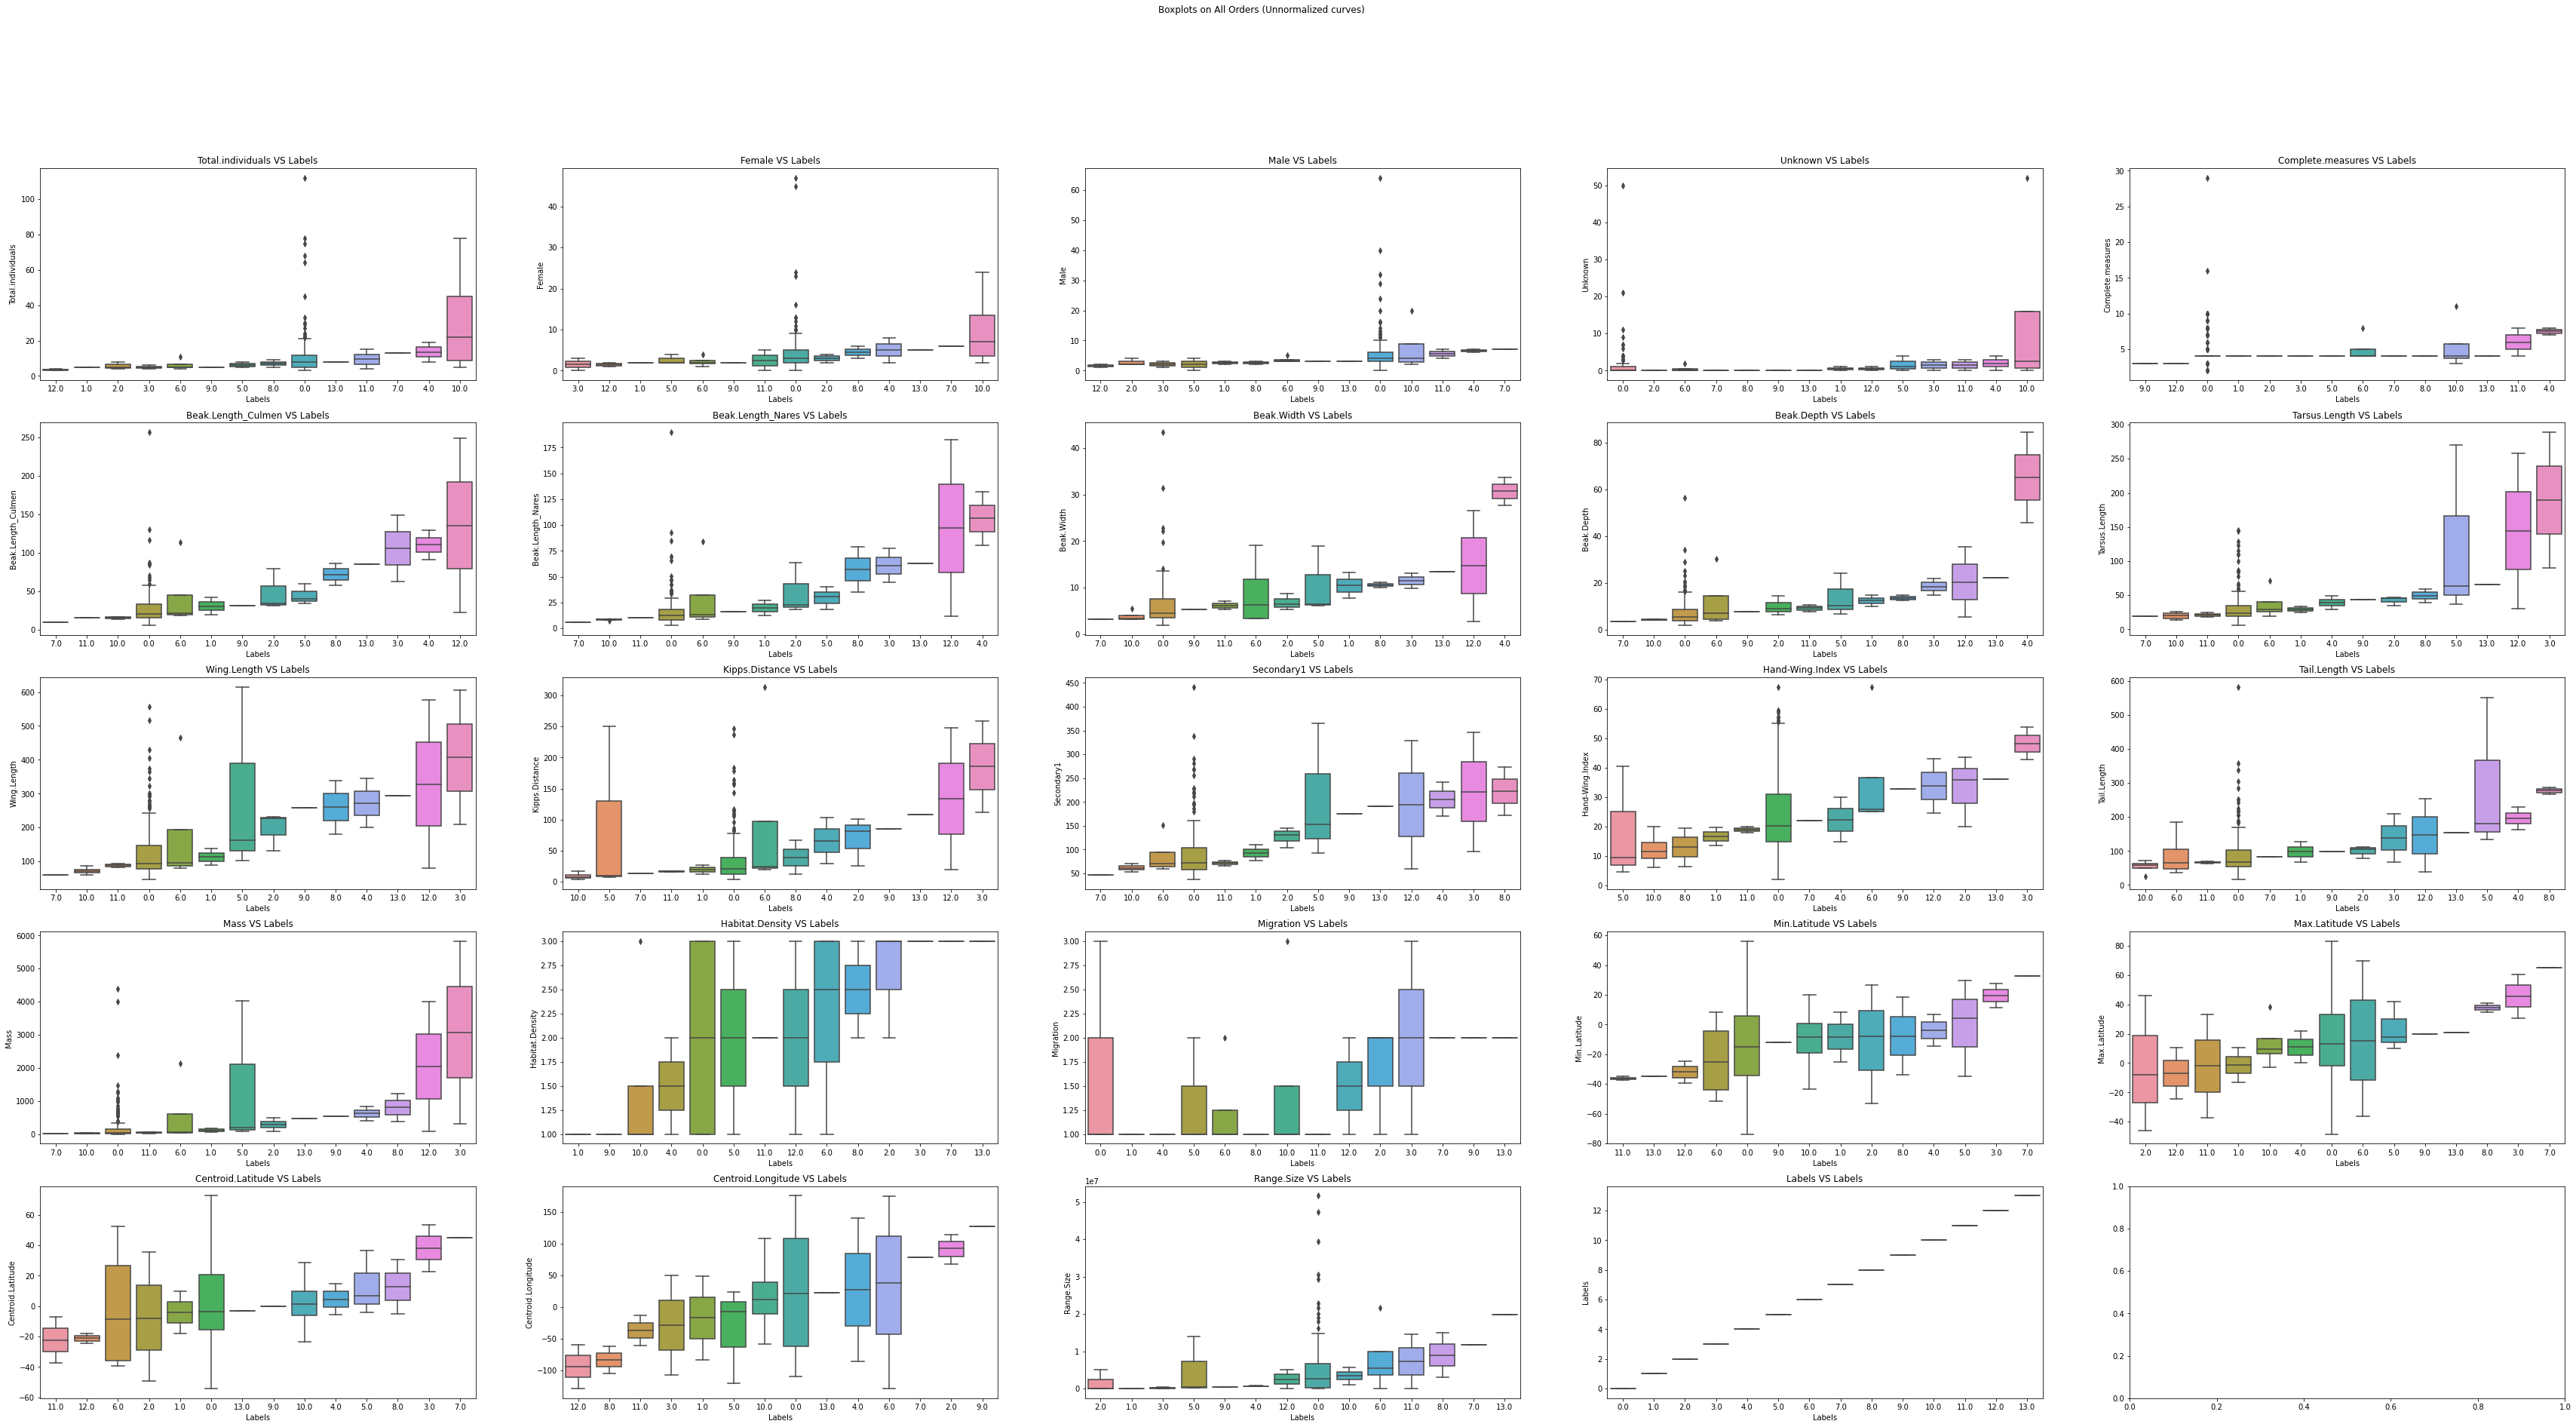

In [ ]:
# Same thing as above but with unnormalized curves
data = df_unnormalized_joined.loc[df_clusterLabels.index]

y_s_num = df_unnormalized_joined.select_dtypes(include = [float, int]).columns # 12 things

rows = 5
cols = 5
tot = rows*cols
fig, axs = plt.subplots(rows, cols, figsize=(60, 30))
fig.suptitle("Boxplots on All Orders (Unnormalized curves)")
for i in range(rows): # 0, 1
    for j in range(cols): # 0, 1, 2
        idx = j + i*(cols)
        if idx < len(y_s_num):
            y = y_s_num[idx] # Name of column in avonet
            # I want my_order to be a list of label nums ordered by their data median
            my_order = data.groupby(["Labels"])[y].median().sort_values().index # Sort by feature medians in ascending order
            sns.boxplot(data = data, 
                x = data["Labels"], y = data[y],
                ax = axs[i, j],
                order = my_order)
            
            axs[i, j].set_xlabel("Labels")
            axs[i, j].set_ylabel(f"{y}")
            axs[i, j].set_title(f"{y} VS Labels")
        

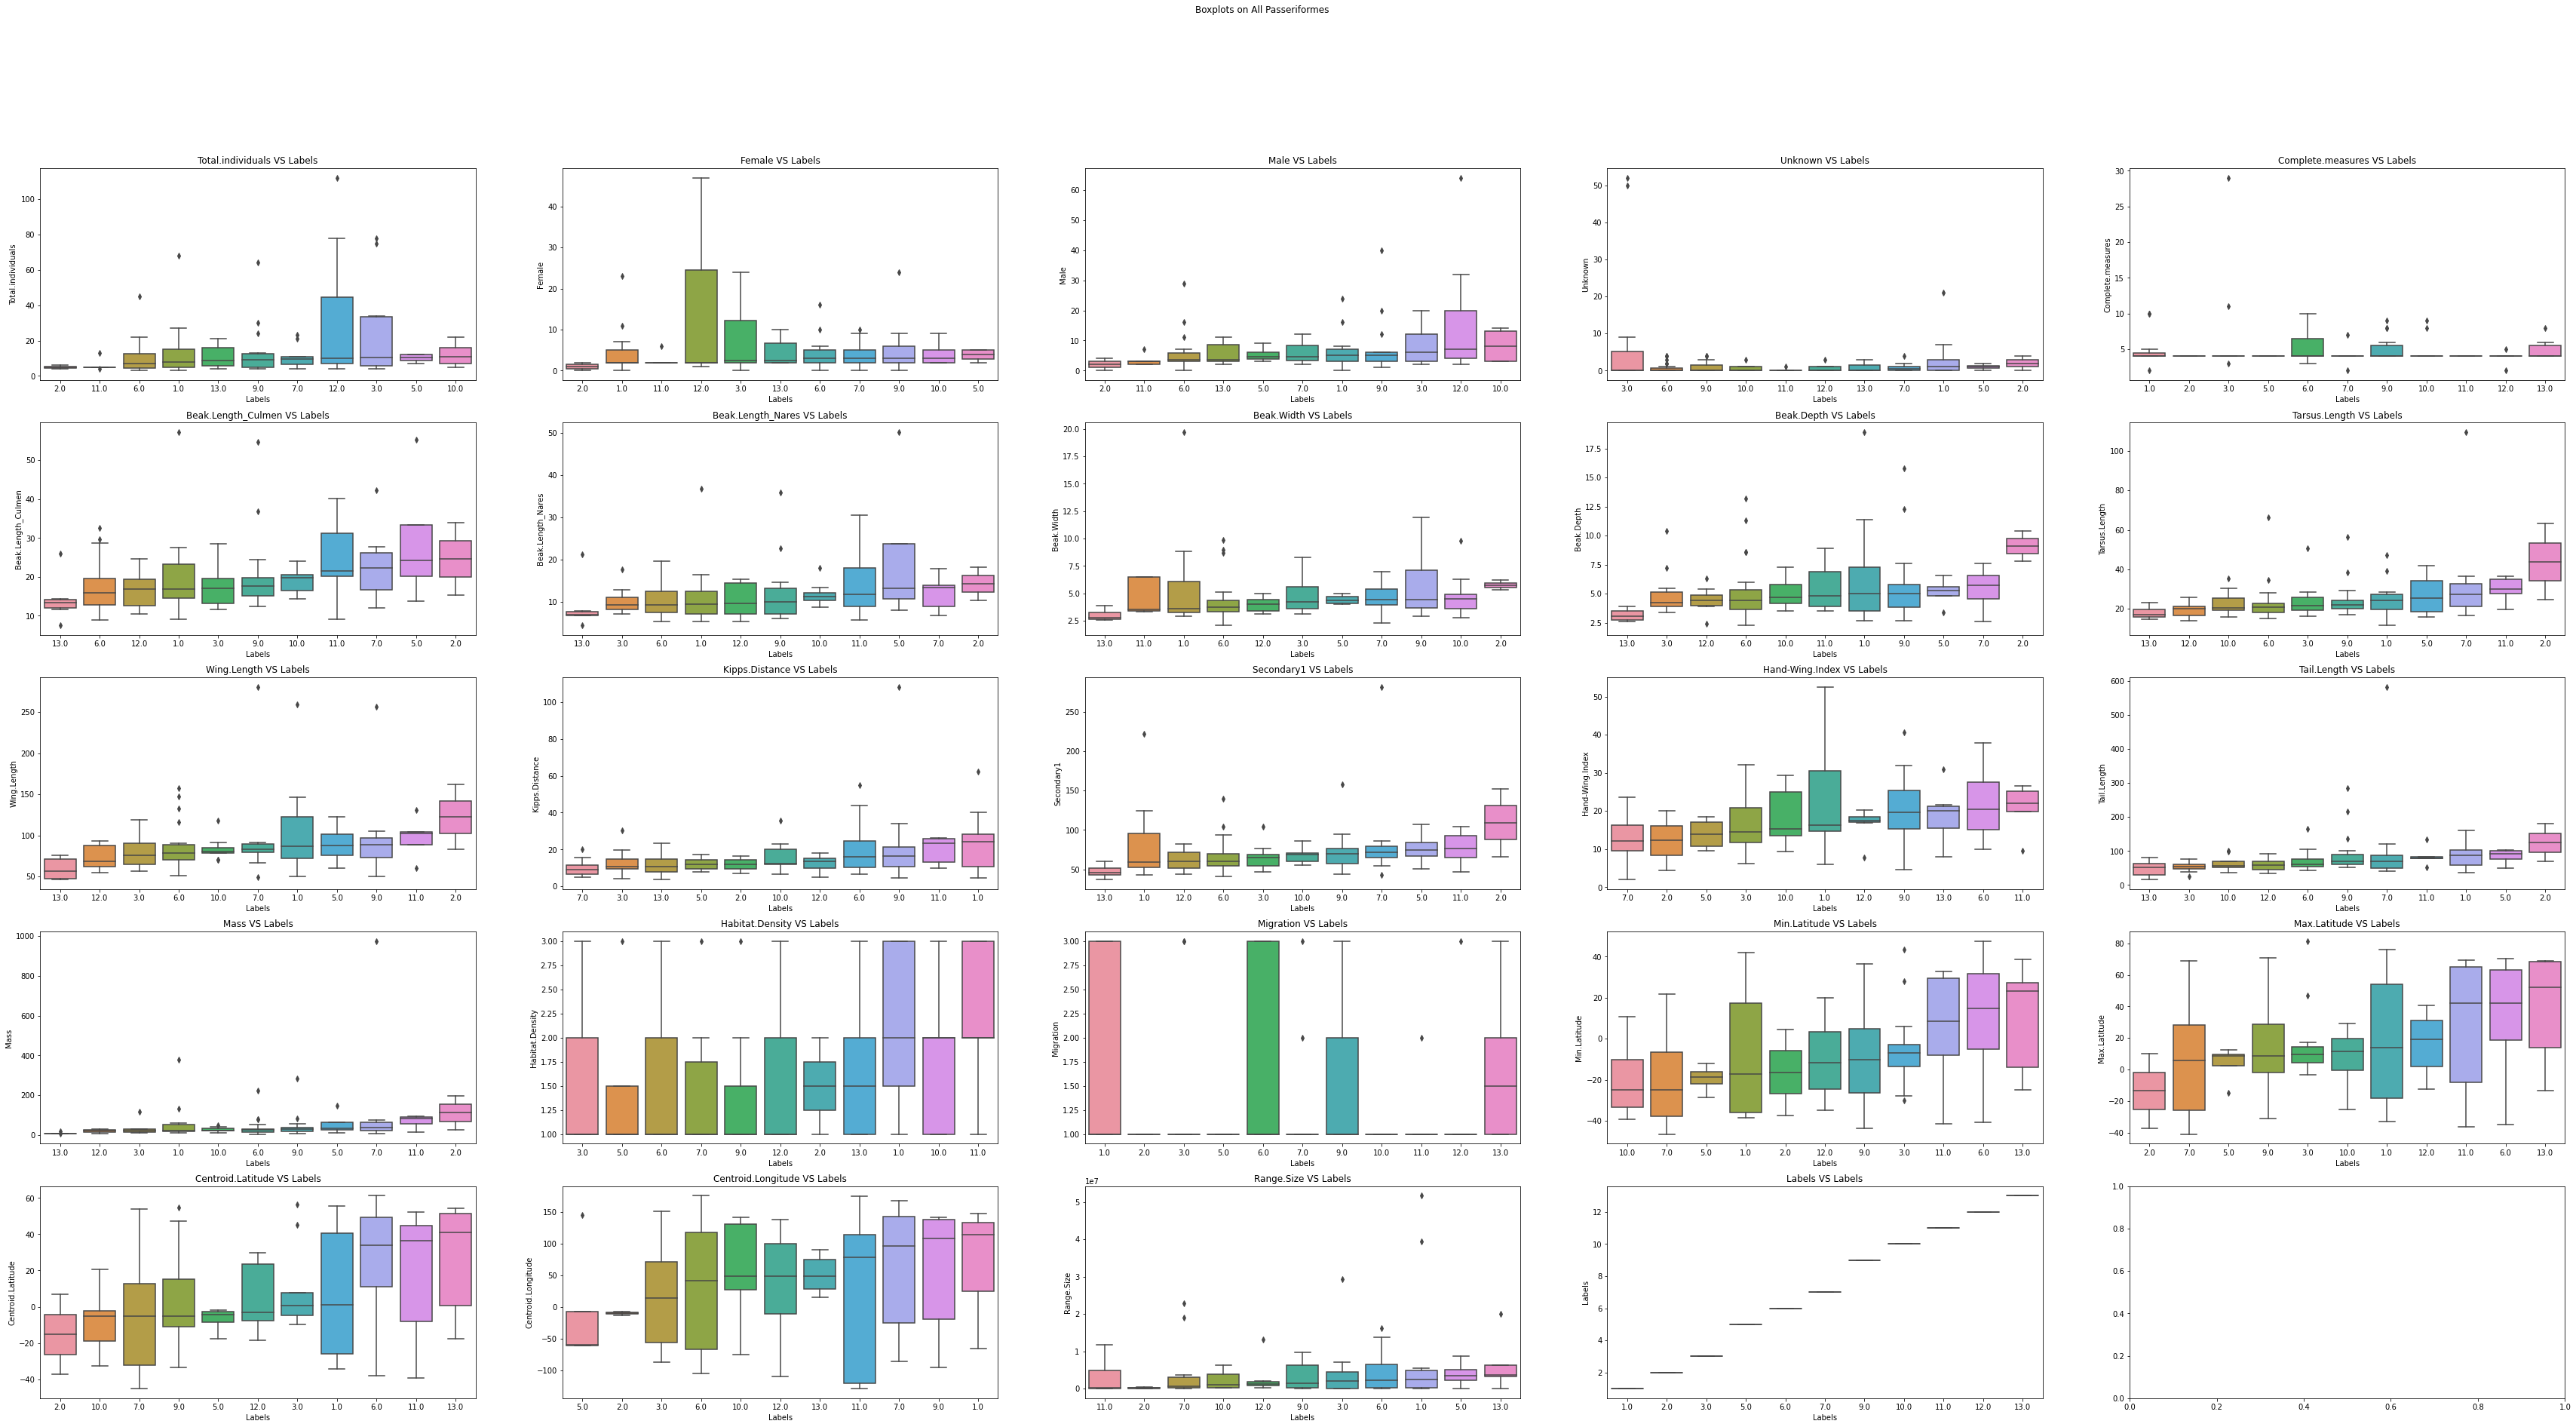

In [ ]:
'''
Is there correlation of cluster labels through the features in AVONET Data


There seems to be some sort of connection between some size attributes and Cluster 10
however, cluster 10 only has ~5 samples.

When examining clusters with high counts (>20), Labels 1 and 2 display similar 
values with very low variation.

Cluster 8 (around 7 samples) stands out on hand-wind index but is normal on all
other traits.
'''

y_s_num = df_joined_passeriformes.select_dtypes(include=[int, float]).columns # 12 things
data = df_joined_passeriformes

rows = 5
cols = 5
tot = rows*cols
fig, axs = plt.subplots(rows, cols, figsize=(60, 30))
fig.suptitle("Boxplots on All Passeriformes")
for i in range(rows): # 0, 1
    for j in range(cols): # 0, 1, 2
        idx = j + i*(cols)
        if idx < len(y_s_num):
            y = y_s_num[idx]
            my_order = data.groupby(["Labels"])[y].median().sort_values().index # Sort by feature medians in ascending order
            sns.boxplot(data = data, 
                x = data["Labels"], y = data[y],
                ax = axs[i, j],
                order = my_order)
            
            axs[i, j].set_xlabel("Labels")
            axs[i, j].set_ylabel(f"{y}")
            axs[i, j].set_title(f"{y} VS Labels")
        

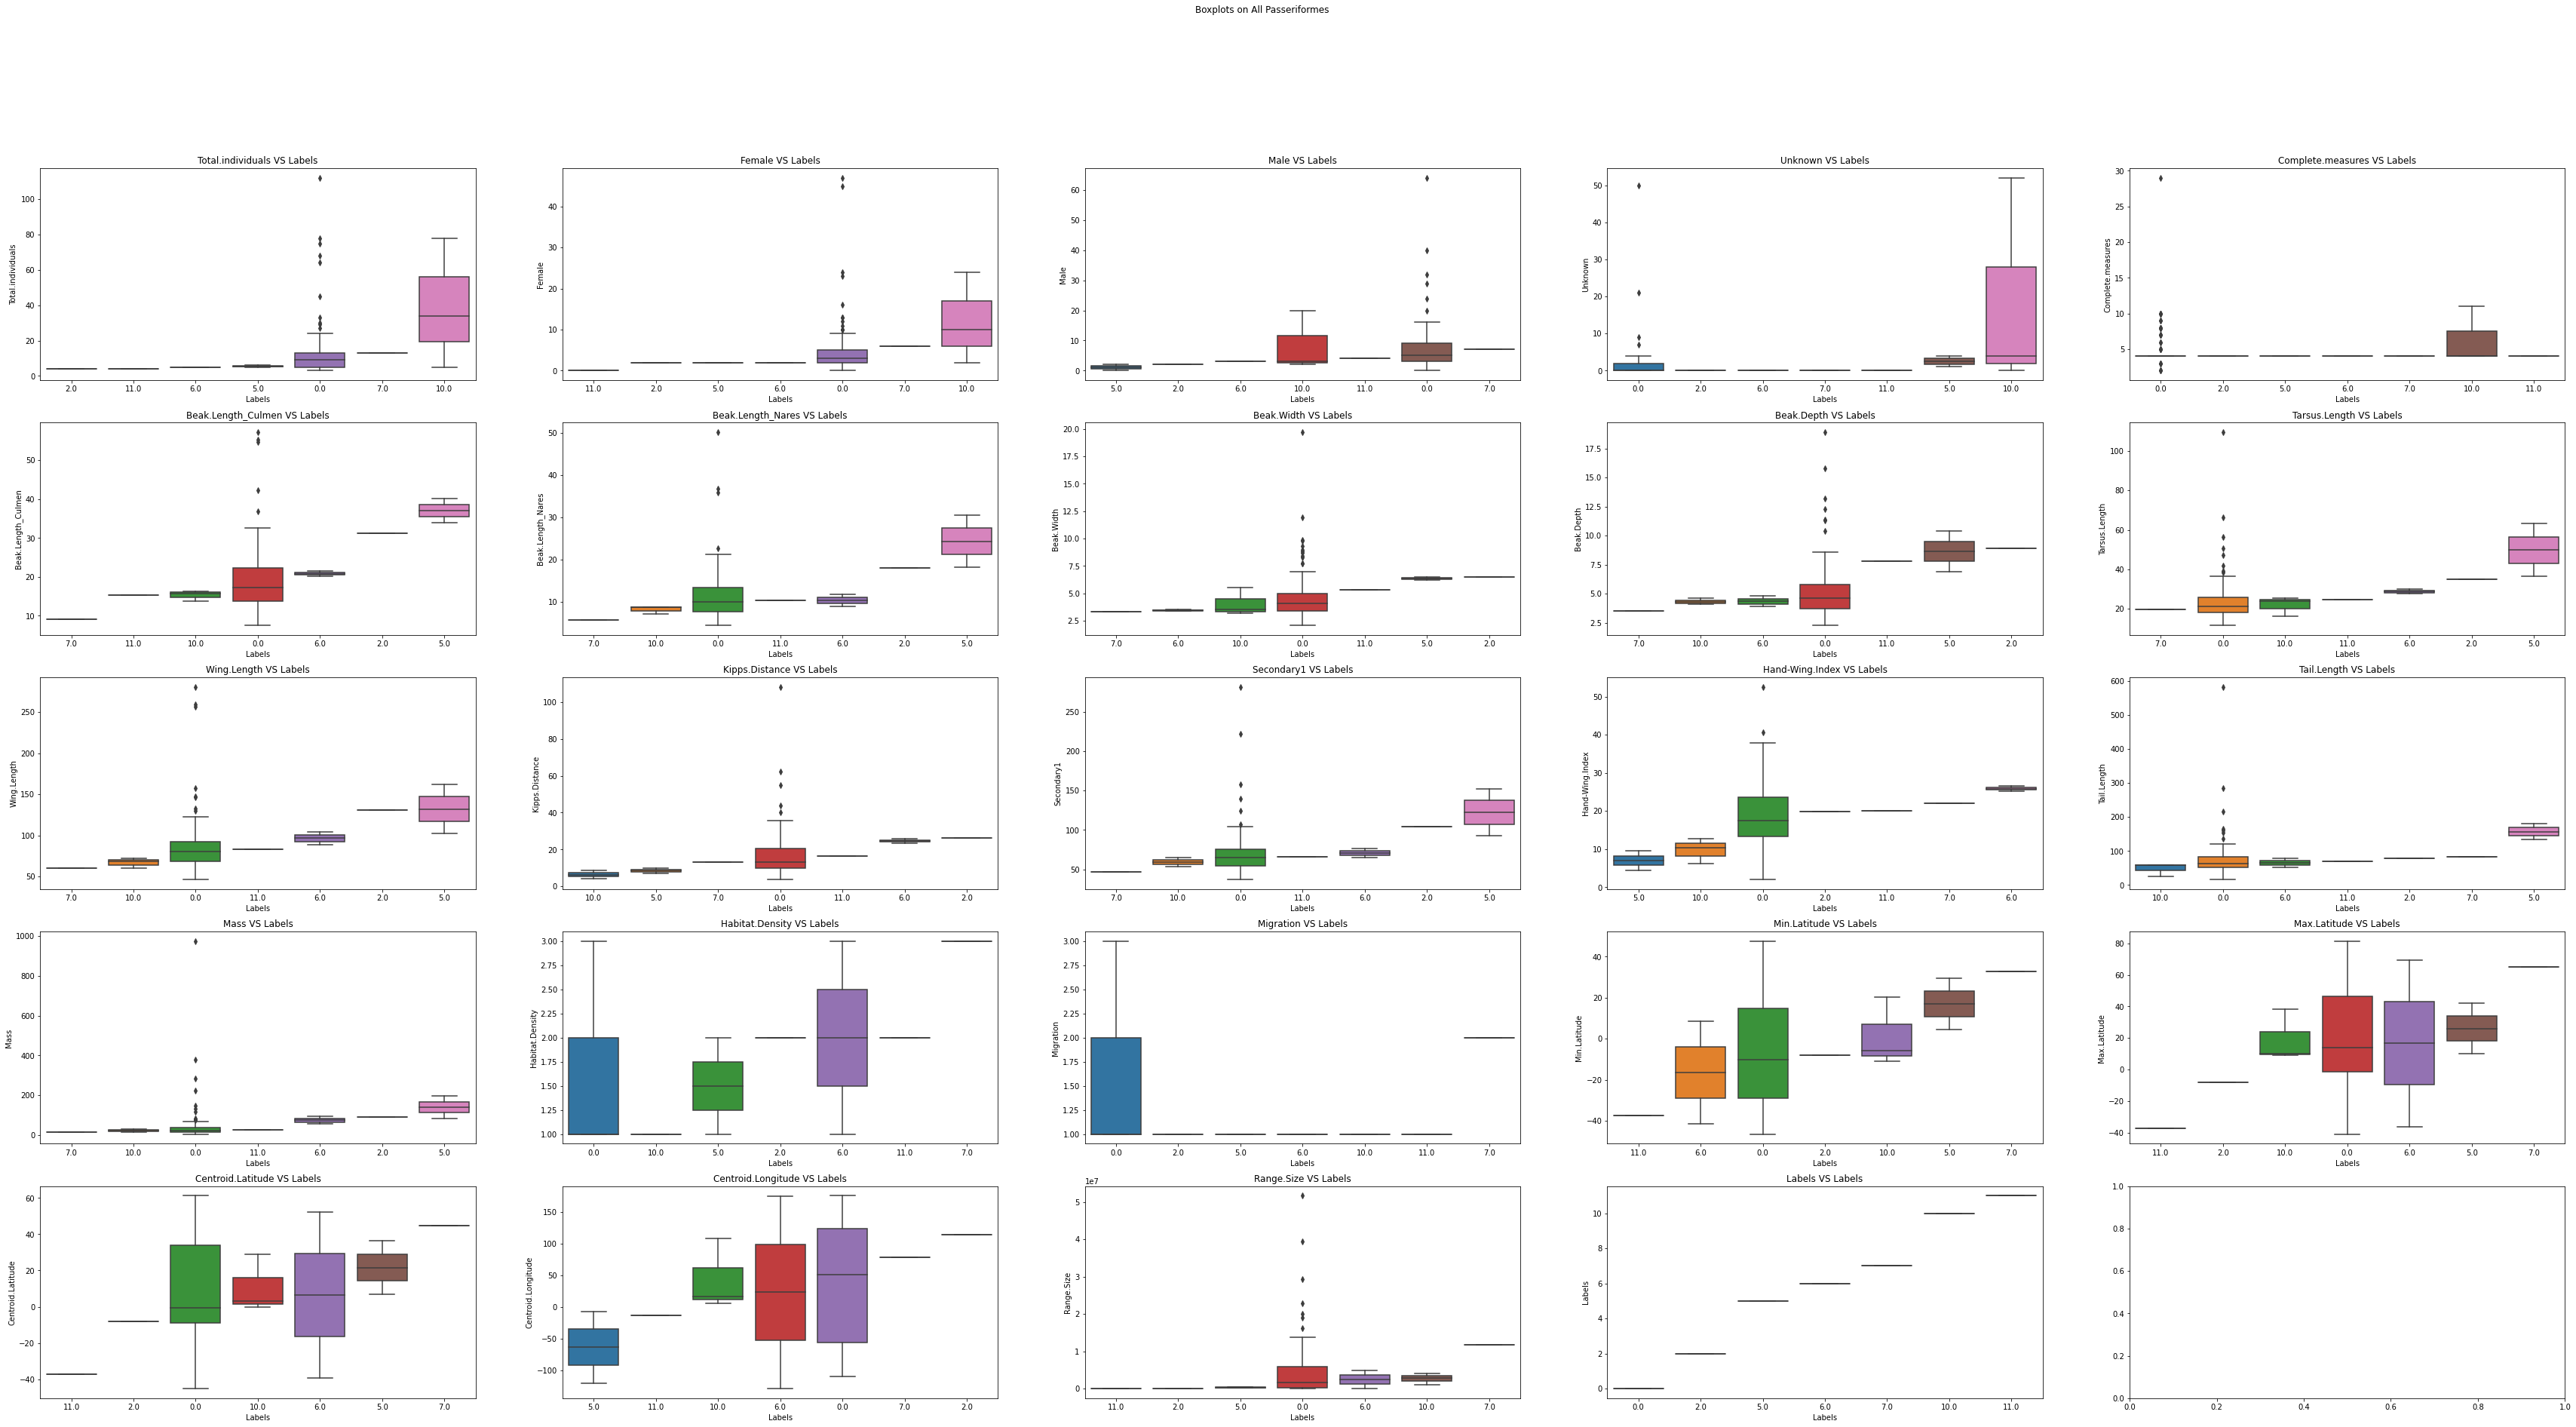

In [ ]:
# Same as above but with unnormalized curve data
# Notice that passeriformes occupy only a subset of clusters
y_s_num = df_unnormalized_joined_passeriformes.select_dtypes(include=[int, float]).columns # 12 things
data = df_unnormalized_joined_passeriformes

rows = 5
cols = 5
tot = rows*cols
fig, axs = plt.subplots(rows, cols, figsize=(60, 30))
fig.suptitle("Boxplots on All Passeriformes")
for i in range(rows): # 0, 1
    for j in range(cols): # 0, 1, 2
        idx = j + i*(cols)
        if idx < len(y_s_num):
            y = y_s_num[idx]
            my_order = data.groupby(["Labels"])[y].median().sort_values().index # Sort by feature medians in ascending order
            sns.boxplot(data = data, 
                x = data["Labels"], y = data[y],
                ax = axs[i, j],
                order = my_order)
            
            axs[i, j].set_xlabel("Labels")
            axs[i, j].set_ylabel(f"{y}")
            axs[i, j].set_title(f"{y} VS Labels")
        

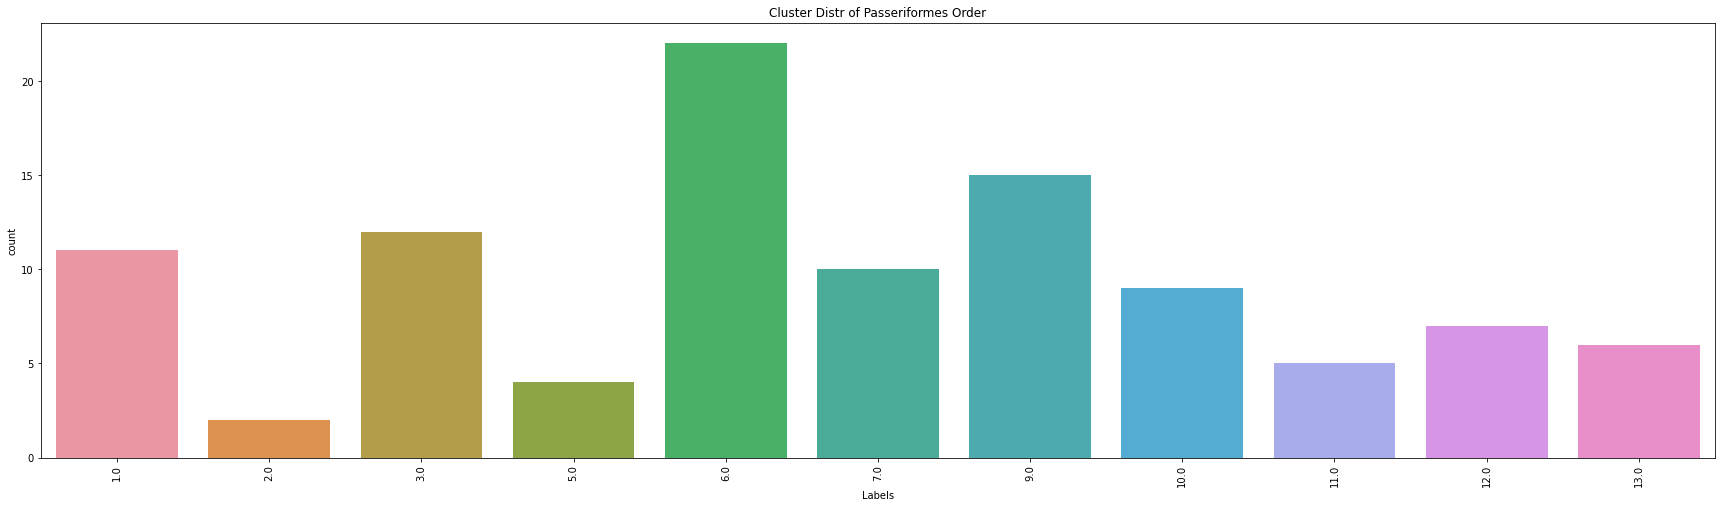

In [ ]:
'''
Plot:
1.) Family distr
2.) Order distr 
3.) Cluster distr by Order
'''

data = df_joined_passeriformes
plt.figure(figsize=(30,8))
plt.xticks(rotation=90)

# ac_countplot = sns.countplot(data = data, x = "Family3", dodge=False)

# plt.figure(figsize=(30,8))
# plt.xticks(rotation=90)
# ac_countplot = sns.countplot(data = data, x = "Order3", dodge=False)

# plt.figure(figsize=(30,8))
plt.title("Cluster Distr of Passeriformes Order")
ac_countplot = sns.countplot(data = df_joined_passeriformes, x = "Labels",  hue="Labels", dodge=False)
ac_countplot.legend_.remove()


In [ ]:
df_joined_passeriformes.loc[df_joined_passeriformes.Labels == 4.0, "Centroid.Longitude"]

Series([], Name: Centroid.Longitude, dtype: float64)

In [ ]:
'''
ANOVA notes (Analysis of variance)

Group/Level: Groups within the same independent variable (14 cluster labels means 14 groups/levels)
INDEPENDENT VAR:    CLUSTER LABELS
DEPENDENT VARS:     FEATURES

NULL HYP: Means are equal
ALT  HYP: Means are not equal

F-value = (btwn group variation/within group variation)
F critical value = specific value to compare F-value to

If F-statistic is statsig -> stuff didn't happen by chance
o.w. throw test data out and don't reject null hyothesis
- Need to use F-stat and P-val for deciding if overall results are significan
    -Significant F-stat just compares joint effect of all variables

Evaluate P-value, then F-value to determine significance. F-value is used only alongside P-value
Req1: Reject Null Hypothesis when P-value < alpha (small).
Req2: Do not reject Null if Critical F-value < F-value, unless P-value is small
- Large F-value means something is significant
- Small P-value means all your results are significant
- Reject Null hypothesis only if P-value < alpha


- Extension of t-test (testing 2 groups to see a sig diff in means)
- ANOVA can test more than 2 groups unlike t-test
- ANOVA looks for within and between group variation
- ANOVA Test software should return F-value (Tells you if means btwn 2 pops are sig diff like T-test)
    - F = 5.2, p-value = 0.1 means that we likely reject NULL HYP.
- F-test tells you if a group is jointly significant vs how a T-test tells you if
  a single variable is statistically significant
- 

- anova and glm are great
    - Run anova on my favorite trait (HWI or mass)
        - ANOVA will tell me if there is something going on within the trait grouping, but not what specifically (nothing like between group diffs)
    - For traits that return a nice ANOVA result, see if their within cluster groupings are sig (T-test on the means of each box -> find p-value for diff)
    - Rerun normalization with something like the median instead of the max
    - Repeat ANOVA to see if anything improved
    - Find a value like inertia or some sort of time series variance 

    - Labels: Curve Cluster Assignments
    - Features: ANOVA Traits (Continuous values)
'''
# See for one example of ANOVA: https://www.scribbr.com/statistics/one-way-anova/#:~:text=Use%20a%20one%2Dway%20ANOVA%20when%20you%20have%20collected%20data,three%20different%20groups%20or%20categories).
# See for more documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
from scipy.stats import f_oneway

def run_anova(data: "df.dataframe"):
    anova_results = dict()
    for trait in data:
        if not isinstance(data[trait].iloc[0], str) and not np.isnan(data[trait].iloc[0]):
            # Feed in list where each entry is a df or something corresponding to one label
            anova_input = []
            for i in sorted(data["Labels"].unique()):
                entry = data.loc[data["Labels"] == i][trait].tolist()
                anova_input.append(entry)
            anova_output = f_oneway(*anova_input)
            anova_results[trait] = anova_output
    return anova_results

In [ ]:
anova_results = run_anova(df_joined)

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [ ]:
a = 0.05
significant_anova_results = {key:val for key, val in anova_results.items() if val[1] < a}
non_significant_anova_results = {key:val for key, val in anova_results.items() if val[1] >=a}

In [ ]:
non_significant_anova_results

{'Complete.measures': F_onewayResult(statistic=0.8425646509336561, pvalue=0.6146610286236871),
 'Hand-Wing.Index': F_onewayResult(statistic=1.519135500047147, pvalue=0.11480756026765862),
 'Habitat.Density': F_onewayResult(statistic=1.223496805678264, pvalue=0.26637112941125085)}

In [ ]:
significant_anova_results

{'Total.individuals': F_onewayResult(statistic=2.1709171437169332, pvalue=0.012713852585819418),
 'Female': F_onewayResult(statistic=2.032415752835686, pvalue=0.020867500674944358),
 'Male': F_onewayResult(statistic=1.8462423343135372, pvalue=0.03979766099144801),
 'Unknown': F_onewayResult(statistic=2.164284197323752, pvalue=0.013022523949280683),
 'Beak.Length_Culmen': F_onewayResult(statistic=5.699833272212592, pvalue=1.303021660618326e-08),
 'Beak.Length_Nares': F_onewayResult(statistic=5.704083942704941, pvalue=1.2817304185216794e-08),
 'Beak.Width': F_onewayResult(statistic=4.138225810334825, pvalue=6.099898504342381e-06),
 'Beak.Depth': F_onewayResult(statistic=5.944977818704252, pvalue=5.053587044263046e-09),
 'Tarsus.Length': F_onewayResult(statistic=7.220261832055812, pvalue=4.0721116476852104e-11),
 'Wing.Length': F_onewayResult(statistic=6.064746228391451, pvalue=3.1886586043437496e-09),
 'Kipps.Distance': F_onewayResult(statistic=3.9510786049284925, pvalue=1.28422859817925

In [ ]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:
df_joined_passeriformes['Centroid.Longitude']
df_joined_passeriformes['Centroid.Latitude']

Latin name
Mohoua_ochrocephala          -45.19
Aegithalos_caudatus           51.23
Atrichornis_clamosus         -34.31
Bombycilla_garrulus           61.26
Phainopepla_nitens            29.77
                              ...  
Mystacornis_crossleyi        -18.74
Vidua_macroura                -3.03
Vireo_altiloquus              20.76
Hypocryptadius_cinnamomeus     7.60
Zosterops_hypoxanthus         -4.25
Name: Centroid.Latitude, Length: 103, dtype: float64

In [ ]:
# geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]


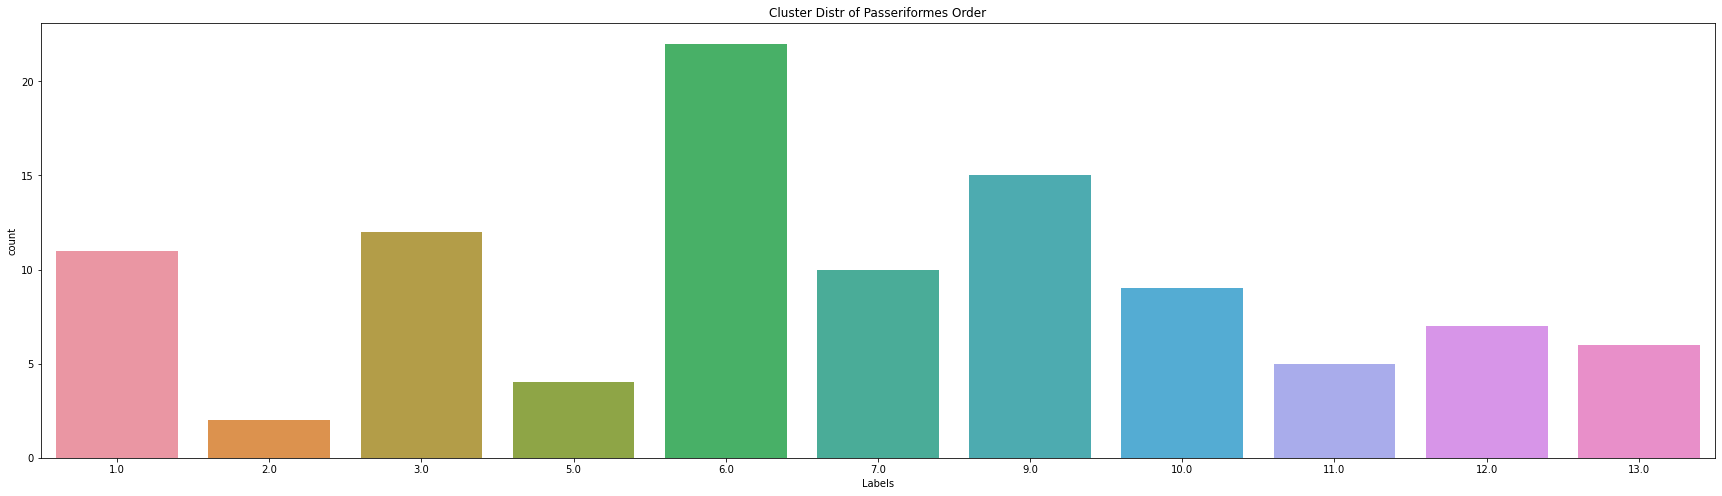

In [ ]:
plt.figure(figsize=(30,8))
plt.title("Cluster Distr of Passeriformes Order")
ac_countplot = sns.countplot(data = df_joined_passeriformes.reset_index(), x = "Labels",  hue="Labels", dodge=False)
ac_countplot.legend_.remove()

In [ ]:
'''
1.) Heatmaps with categorical vars
2.) Look at samples in interesting cluster
3.) t-test with boxplots and cluster labels
4.) Long-Lat plotting with cluster labels
'''

'\n1.) Heatmaps with categorical vars\n2.) Look at samples in interesting cluster\n3.) t-test with boxplots and cluster labels\n4.) Long-Lat plotting with cluster labels\n'